In [2]:
import torch
from typing import List
import pandas as pd
from collections import defaultdict
import bittensor as bt
import requests
import matplotlib.pyplot as plt


This notebook demonstrates the behavior of the validator and how rewards are calculated.
Additianlly it shows how miners are rated and scored in a plot.
Note that dependluing of when this script running you might get not all miners listed because they might have not finished their jobs 

In [3]:
# NASChain NetUID
naschain_uid = 31
subtensor = bt.subtensor()
metagraph = subtensor.metagraph(naschain_uid)
genomaster_ip = 'http://51.161.12.128'
genomaster_port = '5000'
genomaster_valid_endpoint= '/handle_valid_request'

2024-04-12 01:39:49.010 |       INFO       | You are connecting to finney network with endpoint wss://entrypoint-finney.opentensor.ai:443.
2024-04-12 01:39:49.010 |     WARNING      | We strongly encourage running a local subtensor node whenever possible. This increases decentralization and resilience of the network.
2024-04-12 01:39:49.010 |     WARNING      | In a future release, local subtensor will become the default endpoint. To get ahead of this change, please run a local subtensor node and point to it.
2024-04-12 01:39:49.482 |       INFO       | Connected to finney network and wss://entrypoint-finney.opentensor.ai:443.


In [18]:
def reward(df: pd.DataFrame , tolerance : int):
    # Initialize the dictionary to store user scores and job counts
    user_scores = defaultdict(lambda: {'points': 0, 'accepted_jobs': 0, 'rejected_jobs': 0})

    # Process each job batch
    for _, group in df.groupby('Genome_String'):
        responses = group['Response'].tolist()
        user_ids = group['Assigned_User'].tolist()

        # Initialize agreement checks
        agreements = [False] * len(user_ids)  # Default all to False

        # Check pairwise agreement within tolerance for the first element and exact match for others
        for i in range(len(responses)):
            for j in range(i + 1, len(responses)):
                # Check agreement between i and j
                agree_first = abs(responses[i][0] - responses[j][0]) <= tolerance
                agree_second = responses[i][1] == responses[j][1]
                agree_third = responses[i][2] == responses[j][2]

                # Update agreement status
                if agree_first and agree_second and agree_third:
                    agreements[i] = True
                    agreements[j] = True

        # Update scores based on agreement
        for i, user_id in enumerate(user_ids):
            if agreements[i]:
                user_scores[user_id]['points'] += 1
                user_scores[user_id]['accepted_jobs'] += 1
            else:
                user_scores[user_id]['rejected_jobs'] += 1

    # Normalize the points and prepare the lists
    total_points = sum(user['points'] for user in user_scores.values())
    normalized_scores_list = []
    user_ids_list = []

    # Fill the lists with normalized scores and user IDs
    for user_id, score in user_scores.items():
        normalized_score = score['points'] / total_points if total_points > 0 else 0
        normalized_scores_list.append(normalized_score)
        user_ids_list.append(user_id)

    
    
    all_users_in_metagraoh = list(range(int(metagraph.n)))
    all_scores_tensor = torch.zeros(int(metagraph.n))
    # Scatter the scores to the corresponding user IDs
    all_scores_tensor[user_ids_list] = torch.tensor(normalized_scores_list)
    return all_scores_tensor, all_users_in_metagraoh, user_scores

def plot_sorted_rewards(uids, rewards, msgs):
 # Combine uids and rewards into a single list of tuples and sort by rewards in descending order
    combined = list(zip(uids, rewards))
    combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)
    print("-----(TOP Miner (uid,score))-------")
    print(combined_sorted[0])
    uid = int(combined_sorted[0][0])
    print("-----(TOP Miner Score Detail)-------")
    print(msgs[uid])

    # Unzip the sorted combined list back into uids and rewards
    sorted_uids, sorted_rewards = zip(*combined_sorted)
    sorted_uids_str = [str(uid) for uid in sorted_uids]

    # Create the bar chart with Matplotlib
    plt.figure(figsize=(13, 6))
    plt.bar(sorted_uids_str, sorted_rewards, color='royalblue')
    plt.title('Miners sorted by their performance')
    plt.xlabel('uids')
    plt.ylabel('Reward')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


    return plt


2024-04-12 01:46:24.769 |       INFO       | ✅ Validation request successful.
-----(TOP Miner (uid,score))-------
(17, tensor(0.0470))
-----(TOP Miner Score Detail)-------
{'points': 21, 'accepted_jobs': 21, 'rejected_jobs': 0}


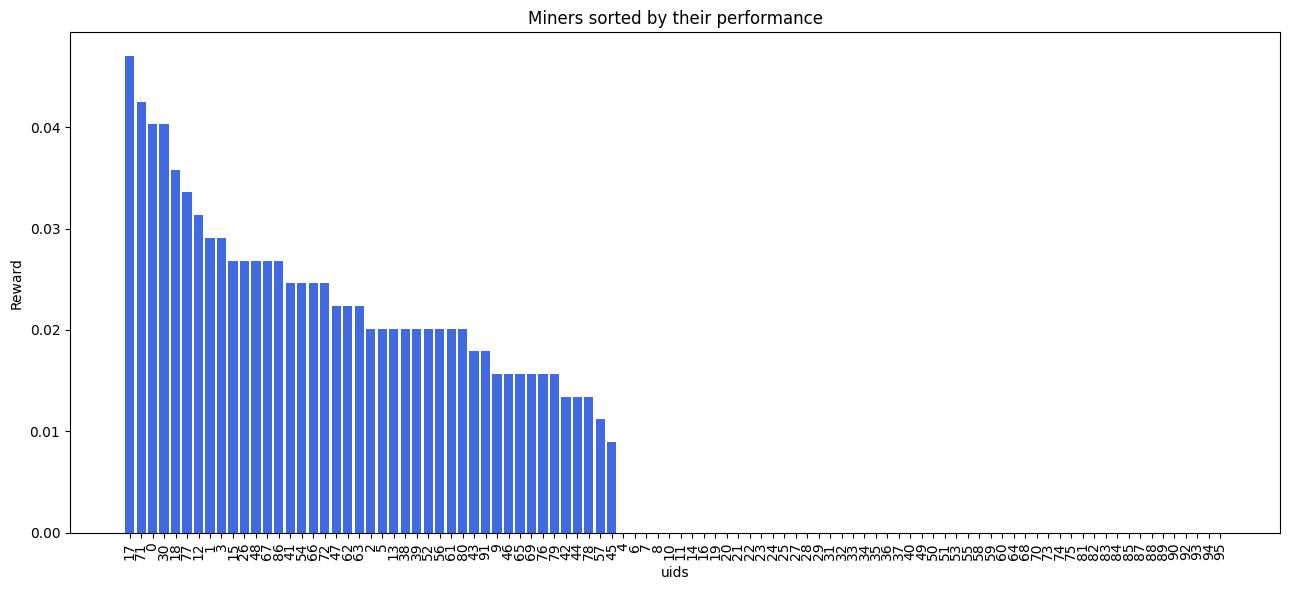

In [19]:
# Establish a connection to GenoMaster to request all the jobs that
# have been completed in the current Genetic Algorithm population.
try:
        # Construct the full URL
        url = genomaster_ip + ':' + genomaster_port + '/handle_valid_request'
        response = requests.get(url)  # This is a synchronous call, consider using an async library if needed
        # Check the status code of the response
        if response.status_code == 200:
            bt.logging.info("✅ Validation request successful.")
            # Convert the JSON response to a pandas DataFrame
            response_data = response.json()
            df = pd.DataFrame(response_data)
            # check to seee if there is new batch of data for validation is ready in genomaster 
            rewards, uids, msgs = reward(df,tolerance=1)
            # print("msgs", msgs[17])
            # print("rewards", list(rewards))
            fig = plot_sorted_rewards(uids, rewards, msgs)
            fig.show()

        
        elif response.status_code == 503:
            bt.logging.warning("⏳ GenoMaster is currently busy, connections will be accepted soon.")

        else:
            # bt.logging.error("❌ Validation request failed.")
            # bt.logging.error("❌ Status code:", response.status_code)
            bt.logging.warning("⏳ Validation request not complete. Message:", response.json().get('message'))

except Exception as e:
        bt.logging.error(f"❌ An error occurred: {e}")
        # Optionally, print the traceback if you need more details
